<a href="https://pymc-devs.github.io/pymc/tutorial.html">PyMC Tutorial</a>
<h3>The Model:</h3>

In [3]:
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np

disasters_array = \
        np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

# switchpoint, all values equally likely a priori
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, doc='Switchpoint[year]')

early_mean = Exponential('early_mean', beta=1.)
late_mean = Exponential('late_mean', beta=1.)

"""In PyMC terminology, the parameter rate is 'deterministic', meaning it's determined explicitly
by observations of its parents. (It's still a random variable)"""
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    # concatenate poisson means
    out = np.empty(len(disasters_array)) # array of size 1 x len(disasters_array) with uninitialized values
    out[:s] = e
    out[s:] = l
    return out                           # looks like [e, e, ..., e, l, l,...,l]

"""Finally, we model the observed random variable, disasters. We have to assign it a probability distribution
because we want to use Bayes' Theorem"""
disasters = Poisson('disasters', mu=rate, value=disasters_array, observed=True) # note the declaration of observed

In [4]:
import disaster_model
disaster_model.switchpoint.parents

{'lower': 0, 'upper': 110}

In [5]:
disaster_model.disasters.parents

{'mu': <pymc.PyMCObjects.Deterministic 'rate' at 0x1061a1950>}

In [6]:
disaster_model.rate.children

{<pymc.distributions.Poisson 'disasters' at 0x1061a1990>}

Notice that parents are dictionaries while children are sets

In [7]:
disaster_model.disasters.value # we set this value

array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1,
       4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3,
       0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2,
       0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [8]:
disaster_model.switchpoint.value # the following values were randomly assigned

array(81)

In [9]:
disaster_model.early_mean.value 

array(0.05980528931627297)

In [10]:
disaster_model.late_mean.value

array(2.202582358708252)

In [11]:
disaster_model.rate.value

array([ 0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05980529,
        0.05980529,  0.05980529,  0.05980529,  0.05980529,  0.05

<p><tt>logp</tt> returns the log of the probability density of a stochastic variable at their current values given the values
of their parents. We can think of the -log probability as a scale of rarity, the larger the more rare.</p>

In [12]:
disaster_model.switchpoint.logp # log of uniform probability evaluated at switchpoint.value

-4.709530201312334

In [13]:
disaster_model.disasters.logp # sum of logs of joint density for each element of disasters 
                              # given parents' (the parameters') values

-622.7366089468533

In [14]:
disaster_model.early_mean.logp # e~exp(1) so log(1*exp(-1*e)) = -e

-0.05980528931627297

In [15]:
disaster_model.late_mean.logp

-2.202582358708252

In [16]:
from math import exp

exp(disaster_model.switchpoint.logp) # because this came from a uniform(0,110) distribution it is == 1/111

0.00900900900900901

In [17]:
"""What logp is really doing for vector valued objects"""
from scipy import stats


arr = np.array([np.log(stats.poisson.pmf(disaster_model.disasters.value[i], mu=disaster_model.rate.value[i])) 
                for i in range(disaster_model.disasters.value.shape[0])])
np.sum(arr)

-622.73660894685349

In [18]:
disaster_model.rate.parents.value # although these values are stochastic, 

{'e': array(0.05980528931627297),
 'l': array(2.202582358708252),
 's': array(81)}

In [32]:
from pymc import MCMC

#Markov Chain Monte Carlo Sampling
M = MCMC(disaster_model)

M.sample(iter=12000, burn=3000, thin=10)

 [-----------------100%-----------------] 12000 of 12000 complete in 1.6 sec

<p>M.sample creates a series of retained samples of (<tt>s, e, l</tt>) from the posterior distribution of the model. <br>
The MCMC joint distribution for <strong>P</strong>(<tt>s, e, l|D)</tt> converges to the true distribution, so we <tt>burn</tt> the <br>
first 1000 values. Because the values are generated by a autoregressive stochastic process close by values <br>
of the samples will be strongly autocorrelated so we take only every 10 values (<tt>thin=10</tt>)</p>

In [33]:
M.trace('switchpoint')[:] # output of the model for switchpoint, there are (12000-3000) / 10 = 900 retained values

array([43, 40, 40, 36, 41, 42, 37, 42, 37, 41, 42, 40, 39, 41, 40, 36, 40,
       39, 37, 46, 40, 36, 37, 42, 40, 41, 40, 36, 39, 40, 40, 43, 44, 43,
       39, 41, 36, 40, 38, 42, 37, 42, 40, 37, 46, 39, 42, 39, 37, 37, 36,
       41, 41, 41, 41, 36, 43, 39, 37, 39, 40, 41, 39, 42, 40, 41, 46, 43,
       40, 41, 41, 43, 42, 41, 41, 39, 40, 37, 40, 40, 40, 36, 37, 41, 41,
       41, 41, 40, 39, 39, 41, 40, 39, 35, 39, 41, 44, 39, 41, 41, 37, 40,
       36, 38, 37, 37, 41, 38, 46, 41, 36, 41, 45, 41, 40, 41, 40, 46, 40,
       47, 40, 36, 42, 41, 42, 41, 40, 36, 41, 39, 39, 42, 36, 43, 42, 41,
       39, 41, 42, 36, 39, 37, 41, 40, 36, 41, 40, 43, 40, 43, 43, 37, 36,
       40, 40, 40, 40, 36, 39, 37, 39, 46, 37, 42, 39, 41, 41, 41, 37, 43,
       40, 42, 39, 43, 41, 41, 42, 43, 42, 36, 40, 40, 36, 41, 39, 38, 46,
       40, 41, 41, 41, 46, 40, 41, 37, 40, 38, 39, 40, 42, 39, 39, 39, 42,
       42, 41, 40, 39, 43, 40, 41, 41, 37, 41, 40, 40, 42, 41, 36, 41, 39,
       40, 42, 41, 42, 39

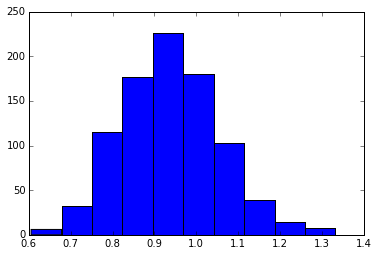

In [34]:
from pylab import hist, show

hist(M.trace(late_mean)[:]) # histogram of marginal posterior probability P(l|D)
show()

Plotting early_mean
Plotting late_mean
Plotting switchpoint


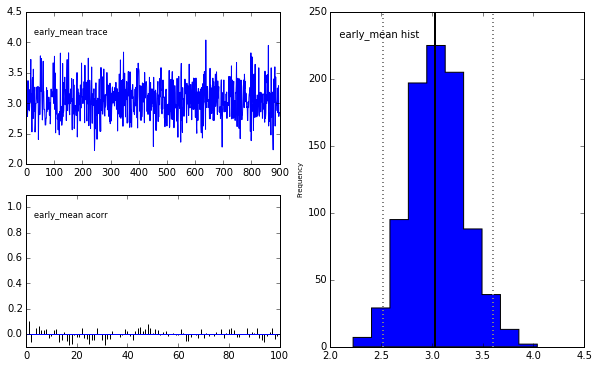

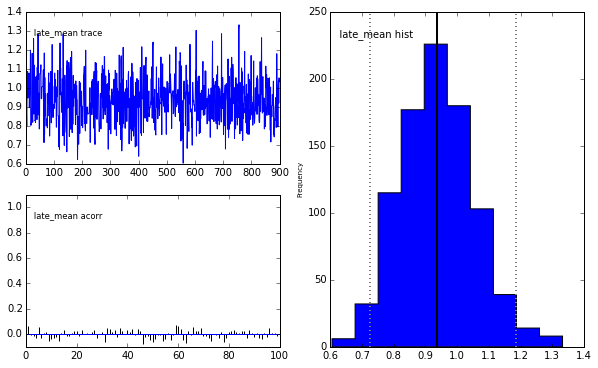

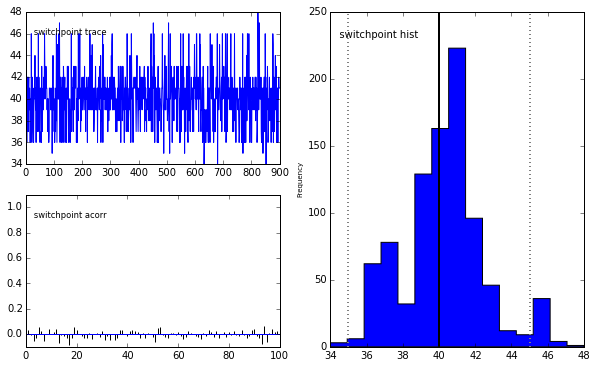

In [35]:
from pymc.Matplot import plot
plot(M)

In [36]:
M.stats()

{'early_mean': {'95% HPD interval': array([ 2.51484891,  3.5987009 ]),
  'mc error': 0.010124377241700405,
  'mean': 3.0500212783909157,
  'n': 900,
  'quantiles': {2.5: 2.5380485710235021,
   25: 2.8627066469130957,
   50: 3.0344447825217329,
   75: 3.2344755204367597,
   97.5: 3.6432076661218611},
  'standard deviation': 0.2748233401210417},
 'late_mean': {'95% HPD interval': array([ 0.72486174,  1.18466654]),
  'mc error': 0.0037733961556360371,
  'mean': 0.93747474375775941,
  'n': 900,
  'quantiles': {2.5: 0.72501071384110327,
   25: 0.85542630781293683,
   50: 0.9361906145376816,
   75: 1.0145064455749853,
   97.5: 1.186620172644258},
  'standard deviation': 0.1169296188692924},
 'rate': {'95% HPD interval': array([[ 2.51484891,  2.51484891,  2.51484891,  2.51484891,  2.51484891,
           2.51484891,  2.51484891,  2.51484891,  2.51484891,  2.51484891,
           2.51484891,  2.51484891,  2.51484891,  2.51484891,  2.51484891,
           2.51484891,  2.51484891,  2.51484891,  2.5